In [1]:
import os
exp_num = 3 #Random Search and Two hidden layers
os.environ["WANDB_API_KEY"] = "00c5bcfd2b2fbe9bce38152923c98635448f8c6f"
EXPERIMENT_NAME = f'MLP_{exp_num}'
NOTE = "Random Seach and Two hidden layers"

In [2]:
os.system('mkdir ../dataset') 
os.system('mkdir ../models')
os.system('wget -q -O ../dataset/KDDTrain+.txt https://raw.githubusercontent.com/acen20/DEL/master/deep-ensemble-jet/dataset/KDDTrain%2B.txt')
os.system('wget -q -O ../dataset/KDDTest+.txt https://raw.githubusercontent.com/acen20/DEL/master/deep-ensemble-jet/dataset/KDDTest%2B.txt')
os.system('wget -q -O ../dataset/KDDTrain+_20Percent.txt https://raw.githubusercontent.com/acen20/DEL/master/deep-ensemble-jet/dataset/KDDTrain%2B_20Percent.txt')
os.system('wget -q -O ../dataset/KDDTest-21.txt https://raw.githubusercontent.com/acen20/DEL/master/deep-ensemble-jet/dataset/KDDTest-21.txt')

0

In [3]:
os.system('pip install wandb -q')
os.system(f'wandb login {os.environ["WANDB_API_KEY"]}')
import wandb

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [4]:
import torch
from torch import nn
from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
#plt.style.use('grayscale')
from sklearn.metrics import precision_recall_curve,RocCurveDisplay
from matplotlib import pyplot
from sklearn.metrics import f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold as KFold
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from sklearn import preprocessing
import time

In [5]:
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
print(f'Using {device} as device')

Using cpu as device


In [8]:
def normalize_data(X):
  mms = MinMaxScaler()
  return mms.fit_transform(X)

In [9]:
def visualize_train_loss(loss_1, labels, epochs, loss_2 = None):
  plt.figure(figsize=(10,4))
  plt.plot(loss_1, linewidth=2)
  if loss_2:
    plt.plot(loss_2, linewidth=2)
  plt.legend(labels)
  plt.ylabel("loss")
  _ = plt.xlabel(f"epochs ({epochs})")

In [10]:
def get_cm(y_test, preds):
    cm = confusion_matrix(y_test, preds)
    tn=cm[1][1] #tn
    fn=cm[0][1] #fn
    fp=cm[1][0] #fp
    tp=cm[0][0] #tp
    acc= (tp+tn)/(tp+tn+fn+fp)
    epsilon = 1e-7 # is used so that to avoid divide by zero error
    precision = tp / (tp + fp + epsilon)
    recall = tp / (tp + fn + epsilon)
    sensitivity,specificity = tp/(tp+fn),tn/(tn+fp)
    print("Test accuracy is:"+str(format(acc,'.4f')))
    print("Precision: "+str(format(precision,'.4f'))+"\nRecall: "+str(format(recall,'.4f')))
    return cm

In [11]:
def disp_PR(y_test, probs, preds, cm, title):
    lr_precision, lr_recall, _ = precision_recall_curve(y_test, probs)
    lr_f1, lr_auc = f1_score(y_test, preds), auc(lr_recall, lr_precision)
    no_skill = len(y_test[y_test==0]) / len(y_test)
    acc = accuracy_score(y_test, preds)
    plt.plot(lr_recall, lr_precision, marker='.', alpha=0.5)
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(title)

    # show the plot
    plt.show()
    disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['normal', 'malicious'])
    disp.plot(cmap="Blues", colorbar = False)
    print(f"F1:\t {lr_f1*100:.3f}%")
    print(f"AUC:\t {lr_auc*100:.3f}%")
    print(f"Accuracy:{acc*100:.3f}%")

## Preprocessing

In [12]:
df=pd.read_csv('../dataset/KDDTrain+.txt', header=None)
df2=pd.read_csv('../dataset/KDDTest+.txt', header=None)
df3=pd.read_csv('../dataset/KDDTest-21.txt', header=None)

In [13]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


In [14]:
df.columns = [str(i) for i in range(0, len(df.columns))]
df2.columns = [str(i) for i in range(0, len(df2.columns))]
df3.columns = [str(i) for i in range(0, len(df3.columns))]

In [15]:
# Replacing Null values with 0. ML classifer cannot learn on Null values
df.fillna(0, inplace=True)
df2.fillna(0, inplace=True)
df3.fillna(0, inplace=True)

In [16]:
# Peak on dataset
df.head()

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


In [17]:
df.shape

(125973, 43)

In [18]:
# Peak on the dataset
df.drop('42',axis=1, inplace=True)
df2.drop('42',axis=1, inplace=True)
df3.drop('42',axis=1, inplace=True)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [19]:
sub_classes = df.iloc[:,41].value_counts()

In [20]:
print(sub_classes)

normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
Name: 41, dtype: int64


In [21]:
r2l = ['ftp_write','guess_passwd', 'imap', 'multihop', 'phf', 'spy','warezclient','warezmaster','xlock', 'xsnoop','named',
       'sendmail','snmpgetattack', 'snmpguess','httptunnel']
u2r = ['buffer_overflow', 'loadmodule','perl','ps','rootkit','sqlattack','xterm']
dos = ['back', 'land', 'neptune', 'smurf', 'teardrop','pod','mailbomb', 'processtable','udpstorm', 'worm','apache2']
probe = ['ipsweep', 'nmap', 'portsweep', 'satan','saint','mscan']
normal = ['normal']

In [22]:
pd.set_option('display.max_rows', None) # or 1000.
train_1 = df['1'].value_counts()
train_1.rename('Train', inplace=True)
test_1 = df2['1'].value_counts()
test_1.rename('Test', inplace=True)
cnct = pd.concat([train_1, test_1], axis = 1)
cnct

,Train,Test
tcp,102689,18880
udp,14993,2621
icmp,8291,1043


In [23]:
train_2 = df['2'].value_counts()
train_2.rename('Train', inplace=True)
test_2 = df2['2'].value_counts()
test_2.rename('Test', inplace=True)
cnct = pd.concat([train_2, test_2], axis = 1)
cnct

,Train,Test
http,40338,7853.0
private,21853,4774.0
domain_u,9043,894.0
smtp,7313,934.0
ftp_data,6860,851.0
eco_i,4586,262.0
other,4359,838.0
ecr_i,3077,752.0
telnet,2353,1626.0
finger,1767,136.0


In [24]:
train_3 = df['3'].value_counts()
train_3.rename('Train', inplace=True)
test_3 = df2['3'].value_counts()
test_3.rename('Test', inplace=True)
cnct = pd.concat([train_3, test_3], axis = 1)
cnct

,Train,Test
SF,74945,14875
S0,34851,2013
REJ,11233,3850
RSTR,2421,669
RSTO,1562,773
S1,365,21
SH,271,73
S2,127,15
RSTOS0,103,2
S3,49,249


In [25]:
df_X = df.drop('41', axis=1)

le = LabelEncoder()
for i in df_X:
  if df_X[i].dtype=='object':
    le.fit(df_X[i])
    df_X[i] = le.transform(df_X[i])
    df2[i] = le.transform(df2[i])
    df3[i] = le.transform(df3[i])
df.iloc[:,:40] = df_X

In [26]:
novel_attacks = df2.drop(df2[df2['41'].isin(df['41'])].index)

In [27]:
novel_attacks = novel_attacks.drop('41', axis=1)

In [28]:
df.iloc[:,:40] = normalize_data(df.iloc[:,:40])
df2.iloc[:,:40] = normalize_data(df2.iloc[:,:40])
df3.iloc[:,:40] = normalize_data(df3.iloc[:,:40])
novel_attacks = normalize_data(novel_attacks)

In [29]:
u2r_attacks = df[df['41'].apply(lambda x: x in u2r)].copy()
r2l_attacks = df[df['41'].apply(lambda x: x in r2l)].copy()
dos_attacks = df[df['41'].apply(lambda x: x in dos)].copy()
probe_attacks = df[df['41'].apply(lambda x: x in probe)].copy()
normal_traffic = df[df['41'].apply(lambda x: x in normal)].copy()

df['41'] = df['41'].map(
    lambda x: 'malicious' if x in r2l 
    else 'malicious' if x in u2r 
    else 'malicious' if x in dos 
    else 'malicious' if x in probe 
    else 'normal' if x is 'normal'
    else x
    )

df2['41'] = df2['41'].map(
    lambda x: 'malicious' if x in r2l 
    else 'malicious' if x in u2r 
    else 'malicious' if x in dos 
    else 'malicious' if x in probe 
    else 'normal' if x is 'normal'
    else x
    )

df3['41'] = df3['41'].map(
    lambda x: 'malicious' if x in r2l 
    else 'malicious' if x in u2r 
    else 'malicious' if x in dos 
    else 'malicious' if x in probe 
    else 'normal' if x is 'normal'
    else x
    )

### Training set value counts

In [30]:
df['41'].value_counts()

normal       67343
malicious    58630
Name: 41, dtype: int64

### Testing set value counts

In [31]:
print(df2['41'].value_counts())

malicious    12833
normal        9711
Name: 41, dtype: int64


In [32]:
#In case of multi-class classification
#df_Y = le.fit(df['41']).transform(df['41'])
#df.iloc[:,41] = df_Y
#df_Y = le.transform(df2['41'])
#df2.iloc[:,41] = df_Y

#In case of binary classification
df.iloc[:,41] = df['41'].map(lambda x: 0 if x=='normal' else 1)
df2.iloc[:,41] = df2['41'].map(lambda x: 0 if x=='normal' else 1)
df3.iloc[:,41] = df3['41'].map(lambda x: 0 if x=='normal' else 1)

X_train = df.drop(['41'],axis=1)
y_train = df['41']

X_test = df2.drop(['41'],axis=1)
y_test = df2['41']
X_test = torch.tensor(np.array(X_test), dtype=torch.float, device=device)

X_test21 = df3.drop(['41'],axis=1)
X_test21 = torch.tensor(np.array(X_test21), dtype=torch.float, device=device)
y_test21 = torch.tensor(df3['41'].to_numpy(), dtype=torch.float)

**Creating TensorDataset**

In [33]:
pt_x_train = torch.tensor(X_train.to_numpy(), dtype=torch.float).to(device)
y = nn.functional.one_hot(torch.tensor(y_train.to_numpy(dtype='int')))
pt_y_train = y.float().to(device)
novel_attacks = torch.tensor(novel_attacks, dtype=torch.float).to(device)
tensor_dataset = TensorDataset(pt_x_train, pt_y_train)

In [34]:
pt_x_train.shape, pt_y_train.shape

(torch.Size([125973, 41]), torch.Size([125973, 2]))

## **MLP**



In [35]:
class MLP(nn.Module):
  data_dim = 41
  def __init__(self, hidden_size):
      super(MLP, self).__init__()
      self.mlp = nn.Sequential(
          nn.Linear(self.data_dim, hidden_size),
          nn.ReLU(),
          nn.BatchNorm1d(hidden_size),
          nn.Linear(hidden_size, hidden_size),
          nn.ReLU(),
          nn.BatchNorm1d(hidden_size)
      )

      self.clf = nn.Sequential(
          nn.Linear(hidden_size,2),
          nn.Sigmoid()
      )

  def forward(self, x):
      features = self.mlp(x)
      return self.clf(features)

In [36]:
def validation_accuracy(model, X, y):
  model.eval()
  with torch.no_grad():
    lr_probs = model(X).detach().squeeze()
  preds = torch.argmax(lr_probs, dim=1).cpu()
  acc = accuracy_score(y, preds)
  model.train()
  return acc

In [37]:
hidden_sizes = [16, 32, 64, 80, 128]
batch_sizes = [64, 128, 256, 512]
epochs_ = [50, 75, 100, 150]
learning_rates = [1e-3, 4e-3, 1e-2, 1e-1]

In [38]:
MAX_COMBINATIONS = 20

In [39]:
hyper_space = []
for hidden_size in hidden_sizes:
    for epochs in epochs_:
        for lr in learning_rates:
            for batch_size in batch_sizes:
                hyper_space.append((hidden_size, epochs, lr, batch_size))

In [40]:
start_time = time.time()

In [41]:
grid_scores = []
iters = 1
#Creating a Random Search
for _ in range(MAX_COMBINATIONS):
    hidden_size, epochs, lr, batch_size = hyper_space[np.random.randint(0, len(hyper_space))]
    hyper_space.remove((hidden_size, epochs, lr, batch_size))
    #Model init
    pt_train = DataLoader(tensor_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
    mlp = MLP(hidden_size).to(device)
    criterion = nn.BCELoss()
    optimizer = torch.optim.SGD(mlp.parameters(), lr = lr)

    #Training Loop
    run = wandb.init(entity='ahsen', project='nids', 
                     name=f'{EXPERIMENT_NAME}_{iters}', 
                     group=EXPERIMENT_NAME, reinit=True,
                     notes=NOTE
                     )
    
    wandb.config["lr"] = lr
    wandb.config["batch_size"] = batch_size
    wandb.config["epochs"] = epochs
    wandb.config["hidden_size"] = hidden_size

    print('========================================================')
    print(f"Hidden Size:{hidden_size}\tEpochs:{epochs}\tLR:{lr}\tBatch Size:{batch_size}")
    num_epochs = epochs
    losses = []
    for epoch in range(num_epochs):
        for instance, y in pt_train:
            output = mlp(instance)
            loss = criterion(output, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        losses.append(loss.item())
        acc = validation_accuracy(mlp, X_test, y_test)
        acc_21 = validation_accuracy(mlp, X_test21, y_test21)
        novel_acc = validation_accuracy(mlp, novel_attacks, 
                                        torch.ones((novel_attacks.shape[0],)))
        wandb.log({'loss':loss.item()})
        print('------------------------------------------------------------------------------')
        print(f'Epoch:\t\t{epoch+1}/{epochs}\nLoss:\t\t{loss.item():.4f}\nAcc:\t\t{acc:.4f}\nAcc21:\t\t{acc_21:.4f}\nNovel:\t\t{novel_acc:.4f}')

    print("*************************************************")
    print(f'Final Score for (H:{hidden_size}, Ep:{epochs}, LR:{lr}, B:{batch_size})')
    print(f'Acc:\t\t{acc:.4f}')
    print(f'Acc21:\t\t{acc_21:.4f}')
    print(f'Novel:\t\t{novel_acc:.4f}')
    #Save scores
    obj = {
      "name":f'{EXPERIMENT_NAME}_{iters}',
      "config":{
        "learning_rate": lr,
        "epochs": epochs,
        "batch_size": batch_size,
        "acc": acc,
        "acc_21": acc_21,
        "novel_acc": novel_acc,
        "hidden_size": hidden_size
        },
      "weights": mlp.state_dict(),
      "losses": losses
    }
    wandb.log({"acc":acc, "acc_21":acc_21, "novel_acc":novel_acc})
    run.finish()
    grid_scores.append(obj)
    elapsed = time.time() - start_time
    print(f'Time Elapsed:\t{elapsed:.0f} seconds')
    iters = iters + 1

wandb: Currently logged in as: ahsen (use `wandb login --relogin` to force relogin)


Hidden Size:80	Epochs:150	LR:0.1	Batch Size:128
------------------------------------------------------------------------------
Epoch:		1/150
Loss:		0.0704
Acc:		0.7813
Acc21:		0.5906
Novel:		0.5288
------------------------------------------------------------------------------
Epoch:		2/150
Loss:		0.0550
Acc:		0.7814
Acc21:		0.6005
Novel:		0.5176
------------------------------------------------------------------------------
Epoch:		3/150
Loss:		0.0263
Acc:		0.7898
Acc21:		0.6098
Novel:		0.5493
------------------------------------------------------------------------------
Epoch:		4/150
Loss:		0.0194
Acc:		0.7936
Acc21:		0.6092
Novel:		0.5432
------------------------------------------------------------------------------
Epoch:		5/150
Loss:		0.0224
Acc:		0.7890
Acc21:		0.6002
Novel:		0.5253
------------------------------------------------------------------------------
Epoch:		6/150
Loss:		0.0566
Acc:		0.7886
Acc21:		0.5984
Novel:		0.5248
----------------------------------------------------

acc,▁
acc_21,▁
loss,█▃▃▂▂▂▂▂▃▁▂▂▁▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁
novel_acc,▁
acc,0.7913
acc_21,0.60414
loss,0.00195
novel_acc,0.45787


Time Elapsed:	470 seconds


Hidden Size:64	Epochs:100	LR:0.01	Batch Size:128
------------------------------------------------------------------------------
Epoch:		1/100
Loss:		0.1078
Acc:		0.7806
Acc21:		0.5844
Novel:		0.4040
------------------------------------------------------------------------------
Epoch:		2/100
Loss:		0.0978
Acc:		0.7671
Acc21:		0.5581
Novel:		0.4083
------------------------------------------------------------------------------
Epoch:		3/100
Loss:		0.0656
Acc:		0.7741
Acc21:		0.5715
Novel:		0.4259
------------------------------------------------------------------------------
Epoch:		4/100
Loss:		0.0563
Acc:		0.7669
Acc21:		0.5570
Novel:		0.4011
------------------------------------------------------------------------------
Epoch:		5/100
Loss:		0.0381
Acc:		0.7633
Acc21:		0.5505
Novel:		0.3893
------------------------------------------------------------------------------
Epoch:		6/100
Loss:		0.0650
Acc:		0.7613
Acc21:		0.5464
Novel:		0.3664
---------------------------------------------------

acc,▁
acc_21,▁
loss,█▅▅▄▅▃▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
novel_acc,▁
acc,0.79436
acc_21,0.60937
loss,0.00728
novel_acc,0.484


Time Elapsed:	766 seconds


Hidden Size:64	Epochs:100	LR:0.004	Batch Size:128
------------------------------------------------------------------------------
Epoch:		1/100
Loss:		0.2260
Acc:		0.7551
Acc21:		0.5365
Novel:		0.4075
------------------------------------------------------------------------------
Epoch:		2/100
Loss:		0.1742
Acc:		0.7638
Acc21:		0.5527
Novel:		0.3947
------------------------------------------------------------------------------
Epoch:		3/100
Loss:		0.1479
Acc:		0.7625
Acc21:		0.5490
Novel:		0.3936
------------------------------------------------------------------------------
Epoch:		4/100
Loss:		0.1095
Acc:		0.7661
Acc21:		0.5555
Novel:		0.3883
------------------------------------------------------------------------------
Epoch:		5/100
Loss:		0.0949
Acc:		0.7676
Acc21:		0.5584
Novel:		0.3856
------------------------------------------------------------------------------
Epoch:		6/100
Loss:		0.0940
Acc:		0.7690
Acc21:		0.5624
Novel:		0.3837
--------------------------------------------------

acc,▁
acc_21,▁
loss,█▅▄▄▃▂▂▂▂▂▂▂▆▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
novel_acc,▁
acc,0.80194
acc_21,0.62869
loss,0.0232
novel_acc,0.3928


Time Elapsed:	1073 seconds


Hidden Size:80	Epochs:75	LR:0.1	Batch Size:128
------------------------------------------------------------------------------
Epoch:		1/75
Loss:		0.0779
Acc:		0.7672
Acc21:		0.5601
Novel:		0.5147
------------------------------------------------------------------------------
Epoch:		2/75
Loss:		0.0440
Acc:		0.7574
Acc21:		0.5414
Novel:		0.4069
------------------------------------------------------------------------------
Epoch:		3/75
Loss:		0.0230
Acc:		0.7544
Acc21:		0.5353
Novel:		0.3445
------------------------------------------------------------------------------
Epoch:		4/75
Loss:		0.0497
Acc:		0.7451
Acc21:		0.5183
Novel:		0.3197
------------------------------------------------------------------------------
Epoch:		5/75
Loss:		0.0218
Acc:		0.7494
Acc21:		0.5246
Novel:		0.3296
------------------------------------------------------------------------------
Epoch:		6/75
Loss:		0.0258
Acc:		0.7709
Acc21:		0.5769
Novel:		0.3904
-----------------------------------------------------------

acc,▁
acc_21,▁
loss,█▅▅▃▂▁▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
novel_acc,▁
acc,0.78593
acc_21,0.59316
loss,0.0022
novel_acc,0.40533


Time Elapsed:	1309 seconds


Hidden Size:32	Epochs:75	LR:0.004	Batch Size:64
------------------------------------------------------------------------------
Epoch:		1/75
Loss:		0.1907
Acc:		0.7826
Acc21:		0.5887
Novel:		0.4157
------------------------------------------------------------------------------
Epoch:		2/75
Loss:		0.1581
Acc:		0.7923
Acc21:		0.6070
Novel:		0.4733
------------------------------------------------------------------------------
Epoch:		3/75
Loss:		0.1546
Acc:		0.7840
Acc21:		0.5907
Novel:		0.4691
------------------------------------------------------------------------------
Epoch:		4/75
Loss:		0.1429
Acc:		0.7834
Acc21:		0.5900
Novel:		0.4701
------------------------------------------------------------------------------
Epoch:		5/75
Loss:		0.1233
Acc:		0.7709
Acc21:		0.5703
Novel:		0.4165
------------------------------------------------------------------------------
Epoch:		6/75
Loss:		0.1082
Acc:		0.7760
Acc21:		0.5803
Novel:		0.4243
----------------------------------------------------------

acc,▁
acc_21,▁
loss,█▇▆▄▄▅▄▂▃▂▃▂▄▃▂▂▂▄▂▁▃▁▂▁▄▁▁▁▂▂▂▂▂▁▁▁▁▁▁▁
novel_acc,▁
acc,0.76051
acc_21,0.5465
loss,0.0279
novel_acc,0.2728


Time Elapsed:	1587 seconds


Hidden Size:128	Epochs:50	LR:0.1	Batch Size:512
------------------------------------------------------------------------------
Epoch:		1/50
Loss:		0.1492
Acc:		0.5629
Acc21:		0.7416
Novel:		0.6341
------------------------------------------------------------------------------
Epoch:		2/50
Loss:		0.0472
Acc:		0.7708
Acc21:		0.5659
Novel:		0.4709
------------------------------------------------------------------------------
Epoch:		3/50
Loss:		0.0359
Acc:		0.7701
Acc21:		0.5634
Novel:		0.4184
------------------------------------------------------------------------------
Epoch:		4/50
Loss:		0.0245
Acc:		0.7805
Acc21:		0.5838
Novel:		0.5235
------------------------------------------------------------------------------
Epoch:		5/50
Loss:		0.0353
Acc:		0.7851
Acc21:		0.5924
Novel:		0.4984
------------------------------------------------------------------------------
Epoch:		6/50
Loss:		0.0239
Acc:		0.7787
Acc21:		0.5814
Novel:		0.4736
----------------------------------------------------------

acc,▁
acc_21,▁
loss,█▃▃▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
novel_acc,▁
acc,0.78424
acc_21,0.59021
loss,0.00321
novel_acc,0.4392


Time Elapsed:	1706 seconds


Hidden Size:32	Epochs:100	LR:0.1	Batch Size:64
------------------------------------------------------------------------------
Epoch:		1/100
Loss:		0.0385
Acc:		0.7698
Acc21:		0.5626
Novel:		0.4608
------------------------------------------------------------------------------
Epoch:		2/100
Loss:		0.0330
Acc:		0.7799
Acc21:		0.5826
Novel:		0.4707
------------------------------------------------------------------------------
Epoch:		3/100
Loss:		0.0197
Acc:		0.7631
Acc21:		0.5517
Novel:		0.3925
------------------------------------------------------------------------------
Epoch:		4/100
Loss:		0.0074
Acc:		0.7814
Acc21:		0.5857
Novel:		0.4024
------------------------------------------------------------------------------
Epoch:		5/100
Loss:		0.0050
Acc:		0.7980
Acc21:		0.6198
Novel:		0.4701
------------------------------------------------------------------------------
Epoch:		6/100
Loss:		0.0392
Acc:		0.7776
Acc21:		0.5777
Novel:		0.4616
-----------------------------------------------------

acc,▁
acc_21,▁
loss,█▄█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁
novel_acc,▁
acc,0.78899
acc_21,0.60059
loss,0.00258
novel_acc,0.42027


Time Elapsed:	2077 seconds


Hidden Size:16	Epochs:50	LR:0.01	Batch Size:128
------------------------------------------------------------------------------
Epoch:		1/50
Loss:		0.2133
Acc:		0.7717
Acc21:		0.5685
Novel:		0.3981
------------------------------------------------------------------------------
Epoch:		2/50
Loss:		0.1596
Acc:		0.7734
Acc21:		0.5712
Novel:		0.4429
------------------------------------------------------------------------------
Epoch:		3/50
Loss:		0.1457
Acc:		0.7869
Acc21:		0.5972
Novel:		0.4827
------------------------------------------------------------------------------
Epoch:		4/50
Loss:		0.1149
Acc:		0.7711
Acc21:		0.5668
Novel:		0.4048
------------------------------------------------------------------------------
Epoch:		5/50
Loss:		0.1254
Acc:		0.7642
Acc21:		0.5535
Novel:		0.3715
------------------------------------------------------------------------------
Epoch:		6/50
Loss:		0.1303
Acc:		0.7741
Acc21:		0.5725
Novel:		0.4419
----------------------------------------------------------

acc,▁
acc_21,▁
loss,█▆▆▄▅▅▄▃▃▄▃▃▄▄▃▃▃▃▂▃▂▂▂▃▂▂▂▂▂▁▃▁▁▁▁▁▁▄▁▂
novel_acc,▁
acc,0.76708
acc_21,0.55713
loss,0.05042
novel_acc,0.38347


Time Elapsed:	2194 seconds


Hidden Size:128	Epochs:100	LR:0.1	Batch Size:128
------------------------------------------------------------------------------
Epoch:		1/100
Loss:		0.0378
Acc:		0.7451
Acc21:		0.5244
Novel:		0.4515
------------------------------------------------------------------------------
Epoch:		2/100
Loss:		0.0291
Acc:		0.7656
Acc21:		0.5587
Novel:		0.3757
------------------------------------------------------------------------------
Epoch:		3/100
Loss:		0.0264
Acc:		0.7711
Acc21:		0.5668
Novel:		0.3992
------------------------------------------------------------------------------
Epoch:		4/100
Loss:		0.0164
Acc:		0.7790
Acc21:		0.5842
Novel:		0.4256
------------------------------------------------------------------------------
Epoch:		5/100
Loss:		0.0084
Acc:		0.7738
Acc21:		0.5797
Novel:		0.3685
------------------------------------------------------------------------------
Epoch:		6/100
Loss:		0.0155
Acc:		0.7679
Acc21:		0.5617
Novel:		0.3283
---------------------------------------------------

acc,▁
acc_21,▁
loss,█▆▄▂▁▂▃▂▂▂▂▂▂▂▂▂▁▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁
novel_acc,▁
acc,0.80274
acc_21,0.6265
loss,0.00047
novel_acc,0.57733


Time Elapsed:	2573 seconds


Hidden Size:80	Epochs:75	LR:0.01	Batch Size:256
------------------------------------------------------------------------------
Epoch:		1/75
Loss:		0.1860
Acc:		0.7566
Acc21:		0.5377
Novel:		0.4032
------------------------------------------------------------------------------
Epoch:		2/75
Loss:		0.1508
Acc:		0.7697
Acc21:		0.5629
Novel:		0.4253
------------------------------------------------------------------------------
Epoch:		3/75
Loss:		0.1118
Acc:		0.7711
Acc21:		0.5657
Novel:		0.4453
------------------------------------------------------------------------------
Epoch:		4/75
Loss:		0.0838
Acc:		0.7775
Acc21:		0.5781
Novel:		0.4864
------------------------------------------------------------------------------
Epoch:		5/75
Loss:		0.0638
Acc:		0.7833
Acc21:		0.5888
Novel:		0.5136
------------------------------------------------------------------------------
Epoch:		6/75
Loss:		0.0529
Acc:		0.7863
Acc21:		0.5943
Novel:		0.5227
----------------------------------------------------------

acc,▁
acc_21,▁
loss,█▇▄▃▂▂▂▂▂▂▂▁▂▂▁▁▁▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
novel_acc,▁
acc,0.8058
acc_21,0.63165
loss,0.00506
novel_acc,0.55333


Time Elapsed:	2758 seconds


Hidden Size:80	Epochs:50	LR:0.01	Batch Size:64
------------------------------------------------------------------------------
Epoch:		1/50
Loss:		0.0597
Acc:		0.7759
Acc21:		0.5749
Novel:		0.4488
------------------------------------------------------------------------------
Epoch:		2/50
Loss:		0.0453
Acc:		0.7699
Acc21:		0.5631
Novel:		0.3947
------------------------------------------------------------------------------
Epoch:		3/50
Loss:		0.0269
Acc:		0.7682
Acc21:		0.5625
Novel:		0.3883
------------------------------------------------------------------------------
Epoch:		4/50
Loss:		0.0261
Acc:		0.7676
Acc21:		0.5597
Novel:		0.3736
------------------------------------------------------------------------------
Epoch:		5/50
Loss:		0.0318
Acc:		0.7705
Acc21:		0.5677
Novel:		0.3739
------------------------------------------------------------------------------
Epoch:		6/50
Loss:		0.0304
Acc:		0.7805
Acc21:		0.5873
Novel:		0.4072
-----------------------------------------------------------

acc,▁
acc_21,▁
loss,█▆▄▄▄▃▃▂▃▂▂▂▂▂▂▂▁▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁▂▁▁▂▁▁▁▁
novel_acc,▁
acc,0.81565
acc_21,0.65131
loss,0.00402
novel_acc,0.53893


Time Elapsed:	2997 seconds


Hidden Size:80	Epochs:150	LR:0.01	Batch Size:64
------------------------------------------------------------------------------
Epoch:		1/150
Loss:		0.0594
Acc:		0.7793
Acc21:		0.5818
Novel:		0.4200
------------------------------------------------------------------------------
Epoch:		2/150
Loss:		0.0312
Acc:		0.8005
Acc21:		0.6219
Novel:		0.5493
------------------------------------------------------------------------------
Epoch:		3/150
Loss:		0.0271
Acc:		0.7862
Acc21:		0.5956
Novel:		0.5080
------------------------------------------------------------------------------
Epoch:		4/150
Loss:		0.0260
Acc:		0.7857
Acc21:		0.5965
Novel:		0.5179
------------------------------------------------------------------------------
Epoch:		5/150
Loss:		0.0273
Acc:		0.7843
Acc21:		0.5926
Novel:		0.4931
------------------------------------------------------------------------------
Epoch:		6/150
Loss:		0.0230
Acc:		0.7788
Acc21:		0.5815
Novel:		0.4667
----------------------------------------------------

acc,▁
acc_21,▁
loss,▆▅▅▆█▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁
novel_acc,▁
acc,0.78642
acc_21,0.59477
loss,0.0008
novel_acc,0.39733


Time Elapsed:	3688 seconds


Hidden Size:64	Epochs:75	LR:0.01	Batch Size:128
------------------------------------------------------------------------------
Epoch:		1/75
Loss:		0.1865
Acc:		0.7727
Acc21:		0.5691
Novel:		0.3755
------------------------------------------------------------------------------
Epoch:		2/75
Loss:		0.1467
Acc:		0.7668
Acc21:		0.5599
Novel:		0.3971
------------------------------------------------------------------------------
Epoch:		3/75
Loss:		0.1060
Acc:		0.7716
Acc21:		0.5682
Novel:		0.4453
------------------------------------------------------------------------------
Epoch:		4/75
Loss:		0.0740
Acc:		0.7691
Acc21:		0.5645
Novel:		0.4504
------------------------------------------------------------------------------
Epoch:		5/75
Loss:		0.0408
Acc:		0.7665
Acc21:		0.5592
Novel:		0.4259
------------------------------------------------------------------------------
Epoch:		6/75
Loss:		0.0483
Acc:		0.7527
Acc21:		0.5324
Novel:		0.3944
----------------------------------------------------------

acc,▁
acc_21,▁
loss,█▆▄▃▃▄▆▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
novel_acc,▁
acc,0.79489
acc_21,0.61131
loss,0.00844
novel_acc,0.47707


Time Elapsed:	3916 seconds


Hidden Size:128	Epochs:150	LR:0.004	Batch Size:512
------------------------------------------------------------------------------
Epoch:		1/150
Loss:		0.2036
Acc:		0.7756
Acc21:		0.5754
Novel:		0.4189
------------------------------------------------------------------------------
Epoch:		2/150
Loss:		0.1663
Acc:		0.7885
Acc21:		0.5992
Novel:		0.4096
------------------------------------------------------------------------------
Epoch:		3/150
Loss:		0.1455
Acc:		0.7881
Acc21:		0.5988
Novel:		0.4077
------------------------------------------------------------------------------
Epoch:		4/150
Loss:		0.1307
Acc:		0.7843
Acc21:		0.5919
Novel:		0.4064
------------------------------------------------------------------------------
Epoch:		5/150
Loss:		0.1180
Acc:		0.7829
Acc21:		0.5891
Novel:		0.4088
------------------------------------------------------------------------------
Epoch:		6/150
Loss:		0.1085
Acc:		0.7838
Acc21:		0.5907
Novel:		0.4144
-------------------------------------------------

acc,▁
acc_21,▁
loss,█▆▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
novel_acc,▁
acc,0.78917
acc_21,0.59992
loss,0.00579
novel_acc,0.4696


Time Elapsed:	4256 seconds


Hidden Size:16	Epochs:100	LR:0.1	Batch Size:128
------------------------------------------------------------------------------
Epoch:		1/100
Loss:		0.0609
Acc:		0.7684
Acc21:		0.5607
Novel:		0.4509
------------------------------------------------------------------------------
Epoch:		2/100
Loss:		0.0508
Acc:		0.8091
Acc21:		0.6375
Novel:		0.6579
------------------------------------------------------------------------------
Epoch:		3/100
Loss:		0.0295
Acc:		0.7978
Acc21:		0.6173
Novel:		0.6269
------------------------------------------------------------------------------
Epoch:		4/100
Loss:		0.0232
Acc:		0.7839
Acc21:		0.5892
Novel:		0.4965
------------------------------------------------------------------------------
Epoch:		5/100
Loss:		0.0153
Acc:		0.7752
Acc21:		0.5743
Novel:		0.4107
------------------------------------------------------------------------------
Epoch:		6/100
Loss:		0.0113
Acc:		0.7776
Acc21:		0.5782
Novel:		0.4064
----------------------------------------------------

acc,▁
acc_21,▁
loss,█▄▂▁▁▁█▁▂▂▃▃▄▃▃▂▂▁▂▁▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
novel_acc,▁
acc,0.77919
acc_21,0.58042
loss,0.00552
novel_acc,0.3664


Time Elapsed:	4488 seconds


Hidden Size:16	Epochs:150	LR:0.001	Batch Size:256
------------------------------------------------------------------------------
Epoch:		1/150
Loss:		0.4062
Acc:		0.7554
Acc21:		0.5484
Novel:		0.3403
------------------------------------------------------------------------------
Epoch:		2/150
Loss:		0.3633
Acc:		0.7886
Acc21:		0.6120
Novel:		0.4632
------------------------------------------------------------------------------
Epoch:		3/150
Loss:		0.3377
Acc:		0.7844
Acc21:		0.5965
Novel:		0.4661
------------------------------------------------------------------------------
Epoch:		4/150
Loss:		0.3172
Acc:		0.7847
Acc21:		0.5943
Novel:		0.4589
------------------------------------------------------------------------------
Epoch:		5/150
Loss:		0.3051
Acc:		0.7810
Acc21:		0.5878
Novel:		0.4469
------------------------------------------------------------------------------
Epoch:		6/150
Loss:		0.2916
Acc:		0.7745
Acc21:		0.5755
Novel:		0.4283
--------------------------------------------------

acc,▁
acc_21,▁
loss,█▇▆▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
novel_acc,▁
acc,0.80301
acc_21,0.62734
loss,0.06593
novel_acc,0.40373


Time Elapsed:	4766 seconds


Hidden Size:16	Epochs:150	LR:0.001	Batch Size:128
------------------------------------------------------------------------------
Epoch:		1/150
Loss:		0.4576
Acc:		0.7642
Acc21:		0.5574
Novel:		0.4413
------------------------------------------------------------------------------
Epoch:		2/150
Loss:		0.3254
Acc:		0.7646
Acc21:		0.5559
Novel:		0.4304
------------------------------------------------------------------------------
Epoch:		3/150
Loss:		0.2375
Acc:		0.7652
Acc21:		0.5550
Novel:		0.3965
------------------------------------------------------------------------------
Epoch:		4/150
Loss:		0.1963
Acc:		0.7560
Acc21:		0.5370
Novel:		0.3557
------------------------------------------------------------------------------
Epoch:		5/150
Loss:		0.1768
Acc:		0.7486
Acc21:		0.5228
Novel:		0.3400
------------------------------------------------------------------------------
Epoch:		6/150
Loss:		0.1705
Acc:		0.7399
Acc21:		0.5060
Novel:		0.3285
--------------------------------------------------

acc,▁
acc_21,▁
loss,█▅▄▄▃▃▃▃▃▂▂▂▂▂▂▃▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
novel_acc,▁
acc,0.78362
acc_21,0.58844
loss,0.02363
novel_acc,0.4944


Time Elapsed:	5116 seconds


Hidden Size:32	Epochs:75	LR:0.004	Batch Size:128
------------------------------------------------------------------------------
Epoch:		1/75
Loss:		0.2775
Acc:		0.7913
Acc21:		0.6052
Novel:		0.5573
------------------------------------------------------------------------------
Epoch:		2/75
Loss:		0.2813
Acc:		0.7953
Acc21:		0.6125
Novel:		0.4976
------------------------------------------------------------------------------
Epoch:		3/75
Loss:		0.2491
Acc:		0.7887
Acc21:		0.6009
Novel:		0.4832
------------------------------------------------------------------------------
Epoch:		4/75
Loss:		0.2235
Acc:		0.7832
Acc21:		0.5915
Novel:		0.4776
------------------------------------------------------------------------------
Epoch:		5/75
Loss:		0.2019
Acc:		0.7873
Acc21:		0.6016
Novel:		0.5165
------------------------------------------------------------------------------
Epoch:		6/75
Loss:		0.1447
Acc:		0.7865
Acc21:		0.5990
Novel:		0.5275
---------------------------------------------------------

acc,▁
acc_21,▁
loss,██▆▄▄▄▃▃▃▂▂▂▂▁▂▂▂▂▁▁▁▁▁▁▂▁▂▃▂▂▁▂▁▁▁▁▁▁▂▁
novel_acc,▁
acc,0.79174
acc_21,0.60557
loss,0.02668
novel_acc,0.5008


Time Elapsed:	5317 seconds


Hidden Size:32	Epochs:75	LR:0.01	Batch Size:256
------------------------------------------------------------------------------
Epoch:		1/75
Loss:		0.2034
Acc:		0.7496
Acc21:		0.5254
Novel:		0.2859
------------------------------------------------------------------------------
Epoch:		2/75
Loss:		0.1622
Acc:		0.7792
Acc21:		0.5885
Novel:		0.5272
------------------------------------------------------------------------------
Epoch:		3/75
Loss:		0.1873
Acc:		0.7478
Acc21:		0.5257
Novel:		0.3776
------------------------------------------------------------------------------
Epoch:		4/75
Loss:		0.1706
Acc:		0.7493
Acc21:		0.5261
Novel:		0.3208
------------------------------------------------------------------------------
Epoch:		5/75
Loss:		0.1411
Acc:		0.7708
Acc21:		0.5684
Novel:		0.4453
------------------------------------------------------------------------------
Epoch:		6/75
Loss:		0.1281
Acc:		0.7856
Acc21:		0.5949
Novel:		0.5243
----------------------------------------------------------

acc,▁
acc_21,▁
loss,█▇▇▅▄▃▃▂▂▂▂▂▂▂▂▂▁▁▃▁▁▁▂▁▁▁▁▂▂▁▁▁▁▁▁▁▂▁▁▁
novel_acc,▁
acc,0.77329
acc_21,0.57046
loss,0.00843
novel_acc,0.35627


Time Elapsed:	5476 seconds


Hidden Size:32	Epochs:100	LR:0.1	Batch Size:512
------------------------------------------------------------------------------
Epoch:		1/100
Loss:		0.1703
Acc:		0.8414
Acc21:		0.7064
Novel:		0.6440
------------------------------------------------------------------------------
Epoch:		2/100
Loss:		0.0948
Acc:		0.7704
Acc21:		0.5644
Novel:		0.4701
------------------------------------------------------------------------------
Epoch:		3/100
Loss:		0.0535
Acc:		0.7627
Acc21:		0.5582
Novel:		0.4976
------------------------------------------------------------------------------
Epoch:		4/100
Loss:		0.0660
Acc:		0.7786
Acc21:		0.5840
Novel:		0.5051
------------------------------------------------------------------------------
Epoch:		5/100
Loss:		0.0698
Acc:		0.8247
Acc21:		0.6835
Novel:		0.6619
------------------------------------------------------------------------------
Epoch:		6/100
Loss:		0.0338
Acc:		0.7688
Acc21:		0.5606
Novel:		0.4424
----------------------------------------------------

acc,▁
acc_21,▁
loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
novel_acc,▁
acc,0.78189
acc_21,0.58684
loss,0.00253
novel_acc,0.392


Time Elapsed:	5649 seconds


In [42]:
highest = 0
for i,score in enumerate(grid_scores):
  if score['config']['acc'] > grid_scores[highest]['config']['acc']:
    highest = i

In [43]:
end_time = time.time()
print("=====================================")
print(f'Total time taken: {int(end_time-start_time)} seconds')
print(f'Best scores with:\t{grid_scores[highest]["name"]}')
print(f'{grid_scores[highest]["config"]}')

Total time taken: 5653 seconds
Best scores with:	MLP_3_11
{'learning_rate': 0.01, 'epochs': 50, 'batch_size': 64, 'acc': 0.8156493967352733, 'acc_21': 0.6513080168776372, 'novel_acc': 0.5389333333333334, 'hidden_size': 80}


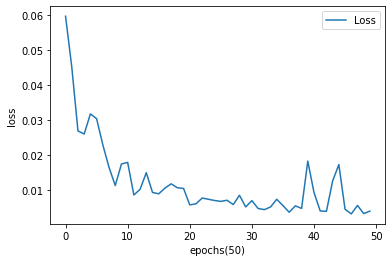

In [44]:
losses = grid_scores[highest]['losses']
num_epochs = grid_scores[highest]['config']['epochs']
plt.plot(losses)
plt.xlabel(f"epochs({num_epochs})")
plt.ylabel(f"loss")
_ = plt.legend(['Loss'])

In [45]:
mlp = MLP(grid_scores[highest]['config']['hidden_size']).to(device)
mlp.load_state_dict(grid_scores[highest]['weights'])
mlp.eval()
with torch.no_grad():
    lr_probs = mlp(X_test).detach().squeeze()
    lr_probs_novel = mlp(novel_attacks).detach().squeeze()
    lr_probs_21 = mlp(X_test21).detach().squeeze()

probs = torch.max(lr_probs, dim=1)
probs_novel = torch.max(lr_probs_novel, dim=1)
probs_21 = torch.max(lr_probs_21, dim=1)

idxs, scores = probs.indices, probs.values
probs = [scores[i].item() if idxs[i]==1 else 1-scores[i].item() for i in range(len(idxs))]

idxs, scores = probs_novel.indices, probs_novel.values
probs_novel = [scores[i].item() if idxs[i]==1 else 1-scores[i].item() for i in range(len(idxs))]

idxs, scores = probs_21.indices, probs_21.values
probs_21 = [scores[i].item() if idxs[i]==1 else 1-scores[i].item() for i in range(len(idxs))]

preds = torch.argmax(lr_probs, dim=1).cpu()
preds_novel = torch.argmax(lr_probs_novel, dim=1).cpu()
preds_21 = torch.argmax(lr_probs_21, dim=1).cpu()

lr_probs = torch.max(lr_probs, dim=1).values
lr_probs_novel = torch.max(lr_probs_novel, dim=1).values
lr_probs_21 = torch.max(lr_probs_21, dim=1).values

probs = np.array(probs)
probs_novel = np.array(probs_novel)
probs_21 = np.array(probs_21)

In [46]:
suspicious = probs[(probs>0.4) & (probs<0.5)].shape[0]

In [47]:
print(f'{suspicious} packets are suspicious')

235 packets are suspicious


In [48]:
cm = get_cm(y_test, preds)

Test accuracy is:0.8156
Precision: 0.7076
Recall: 0.9748


In [49]:
cm_21 = get_cm(y_test21, preds_21)

Test accuracy is:0.6513
Precision: 0.3301
Recall: 0.8936


In [50]:
cm_novel = get_cm(np.ones(novel_attacks.shape[0],), preds_novel)

Test accuracy is:0.5389
Precision: 0.0000
Recall: 0.0000


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in long_scalars
  # This is added back by InteractiveShellApp.init_path()


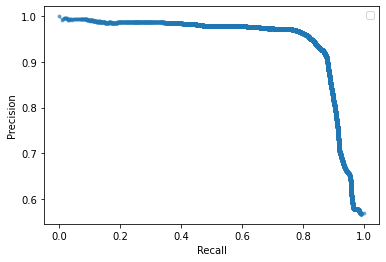

F1:	 81.109%
AUC:	 94.396%
Accuracy:81.565%


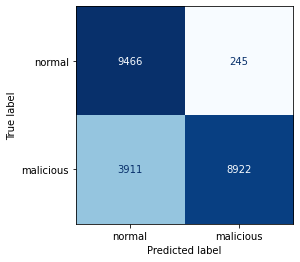

In [51]:
disp_PR(y_test, probs, preds, cm, title = '')

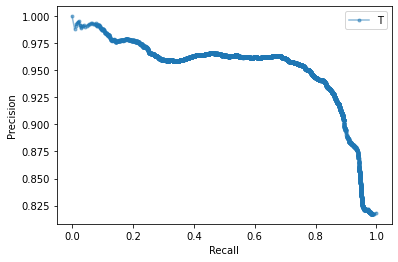

F1:	 73.718%
AUC:	 95.200%
Accuracy:65.131%


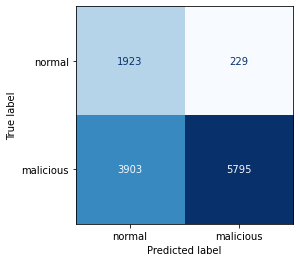

In [52]:
disp_PR(y_test21, probs_21, preds_21, cm_21, title = 'Test21')

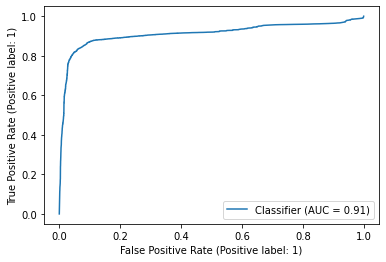

In [53]:
_ = RocCurveDisplay.from_predictions(y_test,probs)

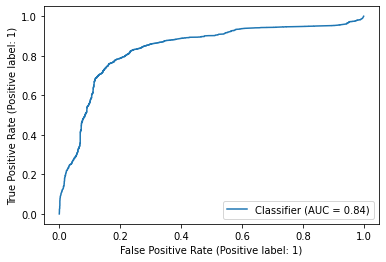

In [54]:
_ = RocCurveDisplay.from_predictions(y_test21,probs_21)

In [55]:
wandb.finish()

In [56]:
torch.save(mlp.state_dict(), 'mlp.pt')